In [1]:
import h5py    
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import nbimporter
import gc

from keras import backend as K 

import tensorflow.compat.v1 as tf

from sklearn.metrics import roc_curve
from scipy import stats
from scipy.stats import norm
from get_p_value import get_p_value
import warnings

Using TensorFlow backend.


Importing Jupyter notebook from get_p_value.ipynb


In [2]:
# Ignore tensorflow deprecation warnings
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
# Prepare GPU environment and define amount of memory to use
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"  # specify which GPU(s) to be used
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.42)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
###################################################################################################################
###################################################################################################################
###############################################                      ##############################################
###############################################     Get p-values     ##############################################
###############################################                      ##############################################
###################################################################################################################
###################################################################################################################

In [5]:
# Define some variables
n_runs = 10             # number of models that have been trained (i.e. number of independent CWoLa runs)
count = 1               # this variable is only defined to keep track of the iterations benchmark and print some info
nbatch = int(256*80)    # batch size

# Define number of signal and background events for the S/B scan. S/B benchmarks denoted as B1-B9
back_scan = [537304, 537304, 537304, 537304, 537304, 537304, 537304, 537304, 537304]
sig_scan = [730, 580, 440, 350, 308, 265, 220, 175, 1]

# Define lists to save information for each benchmark and all CWoLa runs
all_S_B = []             # S/B
all_S_sqrt_B = []        # S/sqrt(B)
all_pvalues = []         # p-value
all_S_after = []         # number of signal events that survive to each cut for a given benchmark and CWoLa run
all_B_after = []         # number of background events that survive to each cut for a given benchmark and CWoLa run
all_S_sqrt_B_after = []  # S/sqrt(B) after each cut for a given benchmark and CWoLa run


# Iterate over S/B benchmarks
for evs in range(len(back_scan)):
    
    print("******************************  Testing benchmark number %i...  ******************************" % count)
    
    # Define lists to save information for a given benchmark in all CWoLa runs
    S_B_bench = []               # Initial S/B values in the SR for each CWoLa run on a given benchmark
    S_sqrt_B_bench = []          # Initial S/sqrt(B) values in the SR for each CWoLa run on a given benchmark
    pvalues_bench = []           # p-values for each CWoLa run on a given benchmark
    S_after_bench = []           # number of S events that survive to each cut for each CWoLa run on a given benchmark
    B_after_bench = []           # number of B events that survive to each cut for each CWoLa run on a given benchmark
    S_sqrt_B_after_bench = []    # S/sqrt(B) values in the SR for each CWoLa run on a given benchmark after the cut

    # Iterate over each independent CWoLa run
    for counter in range(1, 1+n_runs):

        # Load the information for a given CWoLa run
        extra_filename = '/home/pablo/Documentos/lbl/olympics/anomaly_detection_analysis/CWoLa_signal_m500_efficiency_large_data/extra_info_B%d_%d/extra_info.hdf5' % (count, counter)
        h5_results = h5py.File(extra_filename, 'r')

        # Store the information
        X_test_list = h5_results['X_test_list'][:]
        X_test_raw_list = h5_results['X_test_raw_list'][:]
        bins = h5_results['bins'][0,:]
        n_signal = int(h5_results['bench_info'][0])
        n_background = int(h5_results['bench_info'][1])
        S_B = h5_results['bench_info'][2]
        S_sqrt_B = h5_results['bench_info'][3]
        kfolds = int(h5_results['other'][0,0])
        nbin = int(h5_results['other'][0,1])
        SR_lower_edge = int(h5_results['other'][0,2])
        SR_upper_edge = int(h5_results['other'][0,3])
        SB_lower_edge = int(h5_results['other'][0,4])
        SB_upper_edge = int(h5_results['other'][0,5])

        h5_results.close()
        
        # Save benchmark information
        S_B_bench.append(S_B)
        S_sqrt_B_bench.append(S_sqrt_B)
        
        # Define fit parameters and lists
        npar = 4              # number of parameters for the fit
        make_plot = False     # indicate the fit function if we want to make a plot
        pvalues = []          # save p-value for each cut
        
        print("Testing ensemble model for run %i..." % counter)
        
        
        ###########################################################################################################
        ##############  Look for the threshold that corresponds to a x% signal efficiency in the SR  ##############
        ###########################################################################################################
    
        # Defines lists
        X_ROC = []          # input data that we will use to calculate the ROC curve
        Y_ROC = []          # truth labels that we will use to calculate the ROC curve
        ROC_scores = []     # scores that we will use to calculate the ROC curve
    
        # Iterate over folds
        for k in range(kfolds):
    
            # Load ensemble model
            ensemble_model = load_model("/home/pablo/Documentos/lbl/olympics/anomaly_detection_analysis/CWoLa_signal_m500_efficiency_large_data/ensemble_models_B%d_%d/ensemble_" % (count, counter) + str(k) + ".h5")
    
            # Load test k-fold
            X_test = X_test_list[k]
            Y_test = X_test[:,13]

            # Pick events in the SR only
            Y_test = Y_test[(X_test[:,12] > bins[SR_lower_edge]) & (X_test[:,12] < bins[SR_upper_edge])]
            X_test = X_test[(X_test[:,12] > bins[SR_lower_edge]) & (X_test[:,12] < bins[SR_upper_edge])]
        
            # Save data and truth labels for ROC curve
            X_ROC.append(X_test)
            Y_ROC.append(Y_test)
    
            # Make predictions with ensemble model on test kfold
            scores_test = ensemble_model.predict(X_test[:,:12], batch_size = nbatch).flatten()
    
            # Save scores
            ROC_scores.append(scores_test)

            pass  # End k loop

        # Transform some lists to arrays
        X_ROC = np.concatenate((X_ROC[0], X_ROC[1], X_ROC[2], X_ROC[3], X_ROC[4]), axis=0)
        Y_ROC = np.concatenate((Y_ROC[0], Y_ROC[1], Y_ROC[2], Y_ROC[3], Y_ROC[4]), axis=0)
        ROC_scores = np.concatenate((ROC_scores[0], ROC_scores[1], ROC_scores[2], ROC_scores[3], ROC_scores[4]), axis=0)
        
        # Calculate tpr and fpr
        fpr, tpr, thresholds = roc_curve(Y_ROC, ROC_scores)
        
        # Calculate event selection that corresponds to a given working point of the SIC surve
        threshold_SI_06 = thresholds[np.abs(tpr - 0.06).argmin()]
        threshold_SI_13 = thresholds[np.abs(tpr - 0.13).argmin()]
        threshold_SI_17 = thresholds[np.abs(tpr - 0.17).argmin()]
        
        # Define threshold when there is no signal
        if (count == 9):
            threshold_SI_06 = 0.5
            threshold_SI_13 = 0.5
            threshold_SI_17 = 0.5
            
        ###########################################################################################################
        #################  Select all the events above the calculated threshold and make the fit  #################
        ###########################################################################################################
        
        # Define cuts: we will keep the events above the thresholds corresponding to the 17%, 13% and 6% signal eff
        threshold_list = [0, threshold_SI_17, threshold_SI_13, threshold_SI_06]
        threshold_print = ['0%', '17%', '13%', '6%']

        # Save expected significance after each cut
        S_after_cuts = []
        B_after_cuts = []
        S_sqrt_B_cuts = []
        
        # Iterate over cuts
        for j in range(len(threshold_list)):

            # Define threshold
            thresh = threshold_list[j]
            
            # Define lists
            most_signal_like_counts = []    # save number of signal-like events in each bin
            S_after = 0                     # count number of S events surviving the cut
            B_after = 0                     # count number of B events surviving the cut
            S_after_SR = 0                  # count number of S events surviving the cut in the SR
            B_after_SR = 0                  # count number of B events surviving the cut in the SR

            # Iterate over folds
            for k in range(kfolds):

                # Load ensemble model
                ensemble_model = load_model("/home/pablo/Documentos/lbl/olympics/anomaly_detection_analysis/CWoLa_signal_m500_efficiency_large_data/ensemble_models_B%d_%d/ensemble_" % (count, counter) + str(k) + ".h5")

                # Load test k-fold
                X_test = X_test_list[k]
                X_test_raw = X_test_raw_list[k]
                Y_test = X_test[:,13]

                # Make predictions with ensemble model on test kfold
                scores_test = ensemble_model.predict(X_test[:,:12], batch_size = nbatch).flatten()

                # Define lists
                bincounts = []

                for i in range(nbin):
                    # Get x% most signal-like events and their scores
                    scores_test_binned = scores_test[(X_test_raw[:,12] >= bins[i]) & (X_test_raw[:,12] < bins[i+1])]

                    # Count signal-like events in each bin
                    if (scores_test_binned.shape[0] == 0):
                        bincounts.append(0)
                    else:
                        bincounts.append(len(scores_test_binned[scores_test_binned >= thresh]))

                # Add them to the kfold list
                most_signal_like_counts.append(np.array(bincounts))
                
                # Calculate expected number of signal and background events after the cut
                all_after = X_test[scores_test >= thresh]
                S_after += len(all_after[all_after[:,13] == 1])
                B_after += len(all_after[all_after[:,13] == 0])
                
                # Calculate expected number of signal and background events in the SR after the cut
                all_after_SR = all_after[(all_after[:,12] >= bins[SR_lower_edge]) & (all_after[:,12] < bins[SR_upper_edge])]
                S_after_SR += len(all_after_SR[all_after_SR[:,13] == 1])
                B_after_SR += len(all_after_SR[all_after_SR[:,13] == 0])

            # Transform some lists to arrays
            z1 = np.zeros(nbin, dtype=int)
            for i in range(kfolds):
                z1 += np.array(most_signal_like_counts)[i]
            most_signal_like_counts = z1

            # Copy data in an array with a shorter name
            w1 = np.copy(most_signal_like_counts)
            
            # Calculate expected S/sqrt(B) after the cuts
            S_after_cuts.append(S_after)
            B_after_cuts.append(B_after)
            S_sqrt_B_cuts.append(S_after_SR/np.sqrt(B_after_SR))

            # Define fit range
            if (j == 0):
                start = np.argmax(w1)
            end = nbin
            pplotname = 'cwola_pplot.png'

            # Calculate p-value
            p_val = get_p_value(w1[start:end], bins[start:end+1], npar, make_plot, mask=np.arange(SR_lower_edge,SR_upper_edge), verbose=0)

            # Set the minimum p-value (due to precision issues, the function returns 0 if p-value < 10**-16)
            if (p_val == 0):
                p_val = 10**-16
            
            # Save p-value
            pvalues.append(p_val)

            # Print some useful information
            if (j == 0):
                print('Initial p-value: p0 = %.3e' % p_val)
            else:
                print('p-value for %s signal efficiency: p0 = %.3e' % (threshold_print[j], p_val))

            # Clear memory
            K.clear_session()
            gc.collect()
            del(ensemble_model)
        
        # Add the p-values for each cut to the list
        pvalues_bench.append(pvalues) 
        S_after_bench.append(S_after_cuts)
        B_after_bench.append(B_after_cuts)
        S_sqrt_B_after_bench.append(S_sqrt_B_cuts)
            
        print()
        with np.printoptions(precision=4, suppress=False):
            print('Run number %d: %s' % (counter, repr(np.array(pvalues))))
        print()
        
    # Save information from each individual benchmark
    all_S_B.append(S_B_bench)
    all_S_sqrt_B.append(S_sqrt_B_bench)
    all_pvalues.append(pvalues_bench)
    all_S_after.append(S_after_bench)
    all_B_after.append(B_after_bench)
    all_S_sqrt_B_after.append(S_sqrt_B_after_bench)
    
    print()
    with np.printoptions(precision=8, suppress=False):
        print('Median for benchmark number %d:\n %s' % (count, repr(np.median(pvalues_bench, axis=0))))
        print('MAD for benchmark number %d:\n %s' % (count, repr(stats.median_abs_deviation(pvalues_bench, axis=0))))
    print()

# Define mean S/B ratio for every benchmark
S_B_CW = np.mean(np.array(all_S_B), axis=1)
S_sqrt_B_CW = np.mean(np.array(all_S_sqrt_B), axis=1)

******************************  Testing benchmark number 1...  ******************************
Testing ensemble model for run 1...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.572e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.806e-13

Run number 1: array([1.5717e-01, 1.0000e-16, 1.0000e-16, 1.8063e-13])

Testing ensemble model for run 2...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.434e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 7.772e-16

Run number 2: array([1.4344e-01, 1.0000e-16, 1.0000e-16, 7.7716e-16])

Testing ensemble model for run 3...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.391e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 2.483e-07

Run number 3: array([1.3913e-01, 1.0000e-16, 1.0000e-16, 2.4834e-07])

Testing ensemble model for run 4...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.531e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.000e-16

Run number 4: array([1.5309e-01, 1.0000e-16, 1.0000e-16, 1.0000e-16])

Testing ensemble model for run 5...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.662e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.687e-11


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 5.734e-03

Run number 5: array([1.6624e-01, 1.0000e-16, 1.6869e-11, 5.7338e-03])

Testing ensemble model for run 6...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.768e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 2.220e-15

Run number 6: array([1.7683e-01, 1.0000e-16, 1.0000e-16, 2.2204e-15])

Testing ensemble model for run 7...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.721e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 4.593e-10

Run number 7: array([1.7207e-01, 1.0000e-16, 1.0000e-16, 4.5934e-10])

Testing ensemble model for run 8...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.598e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 8.427e-14

Run number 8: array([1.5982e-01, 1.0000e-16, 1.0000e-16, 8.4266e-14])

Testing ensemble model for run 9...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.727e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 9.403e-12

Run number 9: array([1.7268e-01, 1.0000e-16, 1.0000e-16, 9.4034e-12])

Testing ensemble model for run 10...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 1.725e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 3.560e-05

Run number 10: array([1.7246e-01, 1.0000e-16, 1.0000e-16, 3.5597e-05])


Median for benchmark number 1:
 array([1.63030548e-01, 1.00000000e-16, 1.00000000e-16, 4.79200013e-12])
MAD for benchmark number 1:
 array([9.53884124e-03, 0.00000000e+00, 0.00000000e+00, 4.79156155e-12])

******************************  Testing benchmark number 2...  ******************************
Testing ensemble model for run 1...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.435e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.441e-13


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 4.948e-11


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 9.256e-07

Run number 1: array([2.4352e-01, 5.4412e-13, 4.9484e-11, 9.2556e-07])

Testing ensemble model for run 2...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.347e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 6.494e-11

Run number 2: array([2.3465e-01, 1.0000e-16, 1.0000e-16, 6.4944e-11])

Testing ensemble model for run 3...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.273e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 4.918e-10

Run number 3: array([2.2731e-01, 1.0000e-16, 1.0000e-16, 4.9180e-10])

Testing ensemble model for run 4...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.284e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.021e-14


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: divide by zero encountered in true_divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm


p-value for 6% signal efficiency: p0 = 2.015e-01

Run number 4: array([2.2836e-01, 1.0000e-16, 1.0214e-14, 2.0149e-01])

Testing ensemble model for run 5...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.534e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 4.385e-14


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.793e-12


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 8.039e-06

Run number 5: array([2.5340e-01, 4.3854e-14, 1.7933e-12, 8.0390e-06])

Testing ensemble model for run 6...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.473e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 6.243e-12


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 3.309e-05

Run number 6: array([2.4728e-01, 1.0000e-16, 6.2430e-12, 3.3088e-05])

Testing ensemble model for run 7...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.778e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 2.429e-08

Run number 7: array([2.7781e-01, 1.0000e-16, 1.0000e-16, 2.4286e-08])

Testing ensemble model for run 8...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.337e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.110e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 2.651e-11

Run number 8: array([2.3371e-01, 1.1102e-16, 1.0000e-16, 2.6513e-11])

Testing ensemble model for run 9...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.348e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 9.104e-15


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.018e-14


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 7.341e-13

Run number 9: array([2.3481e-01, 9.1038e-15, 5.0182e-14, 7.3408e-13])

Testing ensemble model for run 10...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 2.614e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
get_p_value_AE.ipynb:37: RuntimeWarning: invalid value encountered in true_divide
  "            return p1*(1.-y)**(p2-xi*p3)*y**-p3\n",
get_p_value_AE.ipynb:127: RuntimeWarning: invalid value encountered in double_scalars
  "            return np.array([p1*(1.-(x/13000.))**(p2-xi*p3)*(x/13000.)**-p3 for x in xdata])\n",
get_p_value_AE.ipynb:127: RuntimeWarning: invalid value encountered in double_scalars
  "            return np.array([p1*(1.-(x/13000.))**(p2-xi*p3)*(x/13000.)**-p3 for x in xdata])\n",


p-value for 6% signal efficiency: p0 = 1.000e-16

Run number 10: array([2.6142e-01, 1.0000e-16, 1.0000e-16, 1.0000e-16])


Median for benchmark number 2:
 array([2.39164341e-01, 1.00000000e-16, 5.15702591e-15, 1.23889201e-08])
MAD for benchmark number 2:
 array([9.45630731e-03, 0.00000000e+00, 5.05702591e-15, 1.23885530e-08])

******************************  Testing benchmark number 3...  ******************************
Testing ensemble model for run 1...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.140e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 3.911e-10


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 3.302e-10


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 3.778e-07

Run number 1: array([3.1399e-01, 3.9113e-10, 3.3018e-10, 3.7776e-07])

Testing ensemble model for run 2...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.118e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 4.441e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 2.220e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 6.566e-09

Run number 2: array([3.1178e-01, 4.4409e-16, 2.2204e-16, 6.5660e-09])

Testing ensemble model for run 3...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.199e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.551e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.172e-07

Run number 3: array([3.1991e-01, 5.5511e-16, 1.0000e-16, 1.1721e-07])

Testing ensemble model for run 4...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.209e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 3.442e-15


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 3.331e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.000e-16

Run number 4: array([3.2092e-01, 3.4417e-15, 3.3307e-16, 1.0000e-16])

Testing ensemble model for run 5...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.090e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 4.441e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:196: RuntimeWarning: divide by zero encountered in double_scalars


p-value for 6% signal efficiency: p0 = 2.267e-06

Run number 5: array([3.0903e-01, 4.4409e-16, 1.0000e-16, 2.2669e-06])

Testing ensemble model for run 6...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.341e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 9.548e-15


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 3.151e-13


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:196: RuntimeWarning: divide by zero encountered in double_scalars
get_p_value_AE.ipynb:37: RuntimeWarning: invalid value encountered in true_divide
  "            return p1*(1.-y)**(p2-xi*p3)*y**-p3\n",
get_p_value_AE.ipynb:127: RuntimeWarning: invalid value encountered in double_scalars
  "            return np.array([p1*(1.-(x/13000.))**(p2-xi*p3)*(x/13000.)**-p3 for x in xdata])\n",
get_p_value_AE.ipynb:127: RuntimeWarning: invalid value encountered in double_scalars
  "            return np.array([p1*(1.-(x/13000.))**(p2-xi*p3)*(x/13000.)**-p3 for x in xdata])\n",


p-value for 6% signal efficiency: p0 = 4.993e-01

Run number 6: array([3.3413e-01, 9.5479e-15, 3.1508e-13, 4.9926e-01])

Testing ensemble model for run 7...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.220e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.643e-14


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.110e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.557e-05

Run number 7: array([3.2196e-01, 1.6431e-14, 1.1102e-16, 1.5571e-05])

Testing ensemble model for run 8...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.148e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/ipykernel_launcher.py:196: RuntimeWarning: divide by zero encountered in double_scalars
get_p_value_AE.ipynb:37: RuntimeWarning: invalid value encountered in true_divide
  "            return p1*(1.-y)**(p2-xi*p3)*y**-p3\n",
get_p_value_AE.ipynb:127: RuntimeWarning: invalid value encountered in double_scalars
  "            return np.array([p1*(1.-(x/13000.))**(p2-xi*p3)*(x/13000.)**-p3 for x in xdata])\n",
get_p_value_AE.ipynb:127: RuntimeWarning: invalid value encountered in double_scalars
  "            return np.array([p1*(1.-(x/13000.))**(p2-xi*p3)*(x/13000.)**-p3 for x in xdata])\n",


p-value for 6% signal efficiency: p0 = 1.000e-16

Run number 8: array([3.1481e-01, 1.0000e-16, 1.0000e-16, 1.0000e-16])

Testing ensemble model for run 9...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.118e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 2.760e-13


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 2.298e-07

Run number 9: array([3.1176e-01, 2.7600e-13, 1.0000e-16, 2.2981e-07])

Testing ensemble model for run 10...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.167e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 2.013e-10


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.647e-12


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 2.912e-08

Run number 10: array([3.1672e-01, 2.0132e-10, 5.6475e-12, 2.9117e-08])


Median for benchmark number 3:
 array([3.15765621e-01, 6.49480469e-15, 1.66533454e-16, 1.73513394e-07])
MAD for benchmark number 3:
 array([4.07480405e-03, 6.22276009e-15, 6.65334537e-17, 1.73513394e-07])

******************************  Testing benchmark number 4...  ******************************
Testing ensemble model for run 1...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.677e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 8.778e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 9.320e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.510e-01

Run number 1: array([0.3677, 0.0878, 0.0932, 0.151 ])

Testing ensemble model for run 2...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.842e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 8.610e-09


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 2.965e-08


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.028e-03

Run number 2: array([3.8420e-01, 8.6100e-09, 2.9653e-08, 1.0281e-03])

Testing ensemble model for run 3...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.825e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.959e-06


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.675e-06


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 6.253e-03

Run number 3: array([3.8251e-01, 1.9586e-06, 5.6749e-06, 6.2531e-03])

Testing ensemble model for run 4...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.785e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 3.318e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 6.700e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 2.366e-03

Run number 4: array([0.3785, 0.0332, 0.067 , 0.0024])

Testing ensemble model for run 5...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.854e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 3.135e-10


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.200e-08


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.000e-16

Run number 5: array([3.8536e-01, 3.1347e-10, 1.1999e-08, 1.0000e-16])

Testing ensemble model for run 6...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.754e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 2.686e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 2.455e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 2.728e-03

Run number 6: array([0.3754, 0.0269, 0.0025, 0.0027])

Testing ensemble model for run 7...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.826e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 4.074e-04


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 9.792e-06


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 3.411e-03

Run number 7: array([3.8259e-01, 4.0739e-04, 9.7922e-06, 3.4106e-03])

Testing ensemble model for run 8...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.779e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 2.274e-06


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.566e-05


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 2.353e-04

Run number 8: array([3.7788e-01, 2.2738e-06, 1.5658e-05, 2.3527e-04])

Testing ensemble model for run 9...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.977e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 9.229e-07


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.022e-04


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.090e-05

Run number 9: array([3.9769e-01, 9.2291e-07, 1.0222e-04, 1.0896e-05])

Testing ensemble model for run 10...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.698e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 6.258e-08


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.328e-06


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 2.776e-15

Run number 10: array([3.6975e-01, 6.2585e-08, 1.3279e-06, 2.7756e-15])


Median for benchmark number 4:
 array([3.80485469e-01, 2.11621465e-06, 1.27250371e-05, 1.69707047e-03])
MAD for benchmark number 4:
 array([4.29397762e-03, 2.11175292e-06, 1.27042112e-05, 1.69162254e-03])

******************************  Testing benchmark number 5...  ******************************
Testing ensemble model for run 1...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.028e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.132e-05


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.000e-16


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
get_p_value_AE.ipynb:37: RuntimeWarning: invalid value encountered in true_divide
  "            return p1*(1.-y)**(p2-xi*p3)*y**-p3\n",
get_p_value_AE.ipynb:127: RuntimeWarning: invalid value encountered in double_scalars
  "            return np.array([p1*(1.-(x/13000.))**(p2-xi*p3)*(x/13000.)**-p3 for x in xdata])\n",
get_p_value_AE.ipynb:127: RuntimeWarning: invalid value encountered in double_scalars
  "            return np.array([p1*(1.-(x/13000.))**(p2-xi*p3)*(x/13000.)**-p3 for x in xdata])\n",


p-value for 6% signal efficiency: p0 = 1.000e-16

Run number 1: array([4.0283e-01, 1.1316e-05, 1.0000e-16, 1.0000e-16])

Testing ensemble model for run 2...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.006e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.102e-05


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.858e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.073e-02

Run number 2: array([4.0059e-01, 5.1023e-05, 1.8575e-03, 1.0730e-02])

Testing ensemble model for run 3...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.999e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 8.029e-06


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 3.596e-04


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 2.465e-01

Run number 3: array([3.9995e-01, 8.0290e-06, 3.5962e-04, 2.4645e-01])

Testing ensemble model for run 4...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.122e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.340e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.845e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.522e-04

Run number 4: array([4.1220e-01, 1.3400e-02, 1.8454e-03, 1.5220e-04])

Testing ensemble model for run 5...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.307e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 8.489e-05


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.124e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.733e-05

Run number 5: array([4.3072e-01, 8.4890e-05, 1.1244e-03, 1.7326e-05])

Testing ensemble model for run 6...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.010e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.060e-10


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 2.497e-09


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.214e-06

Run number 6: array([4.0095e-01, 1.0596e-10, 2.4969e-09, 1.2143e-06])

Testing ensemble model for run 7...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.999e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.052e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 3.981e-05


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 3.046e-03

Run number 7: array([3.9991e-01, 1.0522e-03, 3.9805e-05, 3.0458e-03])

Testing ensemble model for run 8...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 3.963e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.540e-05


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 3.125e-06


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 9.905e-05

Run number 8: array([3.9629e-01, 1.5403e-05, 3.1252e-06, 9.9050e-05])

Testing ensemble model for run 9...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.169e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 3.877e-05


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 3.335e-07


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 3.150e-04

Run number 9: array([4.1687e-01, 3.8769e-05, 3.3349e-07, 3.1500e-04])

Testing ensemble model for run 10...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.099e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 2.782e-07


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 9.571e-10


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
get_p_value_AE.ipynb:37: RuntimeWarning: invalid value encountered in true_divide
  "            return p1*(1.-y)**(p2-xi*p3)*y**-p3\n",
get_p_value_AE.ipynb:127: RuntimeWarning: invalid value encountered in double_scalars
  "            return np.array([p1*(1.-(x/13000.))**(p2-xi*p3)*(x/13000.)**-p3 for x in xdata])\n",
get_p_value_AE.ipynb:127: RuntimeWarning: invalid value encountered in double_scalars
  "            return np.array([p1*(1.-(x/13000.))**(p2-xi*p3)*(x/13000.)**-p3 for x in xdata])\n",


p-value for 6% signal efficiency: p0 = 1.000e-16

Run number 10: array([4.0990e-01, 2.7818e-07, 9.5707e-10, 1.0000e-16])


Median for benchmark number 5:
 array([4.01888717e-01, 2.70857396e-05, 2.14653269e-05, 1.25627520e-04])
MAD for benchmark number 5:
 array([3.78765202e-03, 2.53726179e-05, 2.14648484e-05, 1.25627520e-04])

******************************  Testing benchmark number 6...  ******************************
Testing ensemble model for run 1...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.290e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 3.410e-04


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 3.954e-04


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 5.949e-05

Run number 1: array([4.2904e-01, 3.4097e-04, 3.9544e-04, 5.9494e-05])

Testing ensemble model for run 2...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.315e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.222e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.559e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.511e-01

Run number 2: array([0.4315, 0.0052, 0.0016, 0.1511])

Testing ensemble model for run 3...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.300e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.698e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 9.287e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.468e-01

Run number 3: array([0.43  , 0.1698, 0.0929, 0.1468])

Testing ensemble model for run 4...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.601e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 3.613e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 3.607e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 4.207e-04

Run number 4: array([4.6005e-01, 3.6131e-02, 3.6073e-02, 4.2070e-04])

Testing ensemble model for run 5...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.579e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.495e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.792e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.909e-01

Run number 5: array([0.4579, 0.055 , 0.1792, 0.1909])

Testing ensemble model for run 6...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.342e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.536e-07


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.684e-06


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.449e-03

Run number 6: array([4.3420e-01, 1.5361e-07, 1.6845e-06, 1.4495e-03])

Testing ensemble model for run 7...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.449e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 2.552e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.227e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 8.043e-03

Run number 7: array([0.4449, 0.0255, 0.1227, 0.008 ])

Testing ensemble model for run 8...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.172e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 2.211e-04


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.362e-04


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 3.072e-04

Run number 8: array([4.1718e-01, 2.2111e-04, 1.3625e-04, 3.0721e-04])

Testing ensemble model for run 9...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.539e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 8.758e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 9.754e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 5.844e-02

Run number 9: array([0.4539, 0.0088, 0.0098, 0.0584])

Testing ensemble model for run 10...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.302e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 3.037e-05


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 3.455e-04


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 6.009e-03

Run number 10: array([4.3018e-01, 3.0367e-05, 3.4551e-04, 6.0094e-03])


Median for benchmark number 6:
 array([0.43283202, 0.00699012, 0.00565655, 0.00702626])
MAD for benchmark number 6:
 array([0.00793993, 0.00697486, 0.00558759, 0.00684291])

******************************  Testing benchmark number 7...  ******************************
Testing ensemble model for run 1...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.748e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 2.385e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 2.007e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 8.738e-02

Run number 1: array([0.4748, 0.2385, 0.2007, 0.0874])

Testing ensemble model for run 2...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.684e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 5.680e-02

Run number 2: array([0.4684, 0.5   , 0.5   , 0.0568])

Testing ensemble model for run 3...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.671e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 3.944e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 1.841e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 8.596e-04

Run number 3: array([0.4671, 0.0394, 0.0184, 0.0009])

Testing ensemble model for run 4...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.747e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 3.707e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.084e-01

Run number 4: array([0.4747, 0.5   , 0.3707, 0.1084])

Testing ensemble model for run 5...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.740e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.392e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 8.765e-03


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.327e-02

Run number 5: array([0.474 , 0.0139, 0.0088, 0.0133])

Testing ensemble model for run 6...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.823e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.882e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 2.342e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.342e-01

Run number 6: array([0.4823, 0.1882, 0.2342, 0.1342])

Testing ensemble model for run 7...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.521e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 3.360e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 9.916e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.276e-01

Run number 7: array([0.4521, 0.336 , 0.0992, 0.1276])

Testing ensemble model for run 8...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.762e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 4.958e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 8.190e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 1.406e-01

Run number 8: array([0.4762, 0.4958, 0.0819, 0.1406])

Testing ensemble model for run 9...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.824e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 3.151e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 4.584e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 5.000e-01

Run number 9: array([0.4824, 0.3151, 0.4584, 0.5   ])

Testing ensemble model for run 10...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.823e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 2.859e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 2.421e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 4.891e-04

Run number 10: array([0.4823, 0.2859, 0.2421, 0.0005])


Median for benchmark number 7:
 array([0.4747365 , 0.30050549, 0.21747904, 0.09790794])
MAD for benchmark number 7:
 array([0.00695028, 0.15381315, 0.14442403, 0.04192164])

******************************  Testing benchmark number 8...  ******************************
Testing ensemble model for run 1...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 3.834e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 7.901e-02

Run number 1: array([0.5   , 0.5   , 0.3834, 0.079 ])

Testing ensemble model for run 2...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.982e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 8.238e-02

Run number 2: array([0.4982, 0.5   , 0.5   , 0.0824])

Testing ensemble model for run 3...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 5.999e-02

Run number 3: array([0.5 , 0.5 , 0.5 , 0.06])

Testing ensemble model for run 4...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 5.000e-01

Run number 4: array([0.5, 0.5, 0.5, 0.5])

Testing ensemble model for run 5...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 3.125e-01

Run number 5: array([0.5   , 0.5   , 0.5   , 0.3125])

Testing ensemble model for run 6...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 4.895e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 1.243e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 3.302e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 9.159e-02

Run number 6: array([0.4895, 0.1243, 0.033 , 0.0916])

Testing ensemble model for run 7...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 3.391e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 4.071e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 4.775e-01

Run number 7: array([0.5   , 0.3391, 0.4071, 0.4775])

Testing ensemble model for run 8...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 7.508e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 3.933e-01

Run number 8: array([0.5   , 0.0751, 0.5   , 0.3933])

Testing ensemble model for run 9...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 4.732e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 3.132e-02


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 8.926e-02

Run number 9: array([0.5   , 0.0473, 0.0313, 0.0893])

Testing ensemble model for run 10...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 4.293e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 5.000e-01

Run number 10: array([0.5   , 0.4293, 0.5   , 0.5   ])


Median for benchmark number 8:
 array([0.5       , 0.46466442, 0.5       , 0.20204072])
MAD for benchmark number 8:
 array([0.        , 0.03533558, 0.        , 0.13253788])

******************************  Testing benchmark number 9...  ******************************
Testing ensemble model for run 1...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 5.000e-01

Run number 1: array([0.5, 0.5, 0.5, 0.5])

Testing ensemble model for run 2...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 5.000e-01

Run number 2: array([0.5, 0.5, 0.5, 0.5])

Testing ensemble model for run 3...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 5.000e-01

Run number 3: array([0.5, 0.5, 0.5, 0.5])

Testing ensemble model for run 4...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 5.000e-01

Run number 4: array([0.5, 0.5, 0.5, 0.5])

Testing ensemble model for run 5...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 5.000e-01

Run number 5: array([0.5, 0.5, 0.5, 0.5])

Testing ensemble model for run 6...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 5.000e-01

Run number 6: array([0.5, 0.5, 0.5, 0.5])

Testing ensemble model for run 7...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 5.000e-01

Run number 7: array([0.5, 0.5, 0.5, 0.5])

Testing ensemble model for run 8...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 5.000e-01

Run number 8: array([0.5, 0.5, 0.5, 0.5])

Testing ensemble model for run 9...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 5.000e-01

Run number 9: array([0.5, 0.5, 0.5, 0.5])

Testing ensemble model for run 10...


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Initial p-value: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 17% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 13% signal efficiency: p0 = 5.000e-01


/home/pablo/anaconda3/envs/ML/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


p-value for 6% signal efficiency: p0 = 5.000e-01

Run number 10: array([0.5, 0.5, 0.5, 0.5])


Median for benchmark number 9:
 array([0.5, 0.5, 0.5, 0.5])
MAD for benchmark number 9:
 array([0., 0., 0., 0.])



In [ ]:
# Check the shape of the array. It should be: [# of benchmarks, # of CWoLa runs, # of cuts tested]
np.array(all_pvalues).shape

In [27]:
# Calculate the mean event selection for each benchmark. Shape: [# of benchmarks, # of cuts tested]
ev_sel = np.mean(np.array(all_S_after) + np.array(all_B_after), axis=1) / np.mean(np.array(all_S_after) + np.array(all_B_after), axis=1) * 100

array([3.61725837e-02, 4.04964064e-02, 3.44067303e-02, 8.19014225e-02,
       5.92123254e-02, 1.04221414e-01, 8.70972783e-01, 1.68186424e+00,
       5.17983401e+01])

In [8]:
# Calculate median p-value and mad for each benchmark
p0_median = np.median(np.array(all_pvalues), axis=1)
p0_mad = stats.median_abs_deviation(np.array(all_pvalues), axis=1)
p0_min = np.min(np.array(all_pvalues), axis=1)
p0_max = np.max(np.array(all_pvalues), axis=1)

# Calculate the median naive expected significance in the SR after each cut using S/sqrt(B)
S_sqrt_B_after = np.median(np.array(all_S_sqrt_B_after), axis=1)

# Cut 1: 100% most-signal like events
p0_median_100_tpr = p0_median[:,0]
p0_mad_100_tpr = p0_mad[:,0]
p0_min_100_tpr = p0_min[:,0]
p0_max_100_tpr = p0_max[:,0]

# Cut 2: events with a score above the threshold that corresponds to the 17% signal efficiency
p0_median_017_tpr = p0_median[:,1]
p0_mad_017_tpr = p0_mad[:,1]
p0_min_017_tpr = p0_min[:,1]
p0_max_017_tpr = p0_max[:,1]

# Cut 3: events with a score above the threshold that corresponds to the 13% signal efficiency
p0_median_013_tpr = p0_median[:,2]
p0_mad_013_tpr = p0_mad[:,2]
p0_min_013_tpr = p0_min[:,2]
p0_max_013_tpr = p0_max[:,2]

# Cut 4: events with a score above the threshold that corresponds to the 6% signal efficiency
p0_median_006_tpr = p0_median[:,3]
p0_mad_006_tpr = p0_mad[:,3]
p0_min_006_tpr = p0_min[:,3]
p0_max_006_tpr = p0_max[:,3]

# Define the median naive expected significance in the SR after each cut
S_sqrt_B_after_100_tpr = S_sqrt_B_after[:,0]
S_sqrt_B_after_017_tpr = S_sqrt_B_after[:,1]
S_sqrt_B_after_013_tpr = S_sqrt_B_after[:,2]
S_sqrt_B_after_006_tpr = S_sqrt_B_after[:,3]

print('Initial cut: p0 median, mad, min and max values:')
print(p0_median_100_tpr)
print(p0_mad_100_tpr)
print(p0_min_100_tpr)
print(p0_max_100_tpr)

print()
print('0.17 tpr: p0 median, mad, min and max values:')
print(p0_median_017_tpr)
print(p0_mad_017_tpr)
print(p0_min_017_tpr)
print(p0_max_017_tpr)

print()
print('0.13 tpr: p0 median, mad, min and max values:')
print(p0_median_013_tpr)
print(p0_mad_013_tpr)
print(p0_min_013_tpr)
print(p0_max_013_tpr)

print()
print('0.06 tpr: p0 median, mad, min and max values:')
print(p0_median_006_tpr)
print(p0_mad_006_tpr)
print(p0_min_006_tpr)
print(p0_max_006_tpr)

Initial cut: p0 median, mad, min and max values:
[0.16303055 0.23916434 0.31576562 0.38048547 0.40188872 0.43283202
 0.4747365  0.5        0.5       ]
[0.00953884 0.00945631 0.0040748  0.00429398 0.00378765 0.00793993
 0.00695028 0.         0.        ]
[0.1391319  0.22731496 0.30902555 0.36767539 0.39629011 0.41718371
 0.45214552 0.48945085 0.5       ]
[0.17683367 0.27780797 0.33413149 0.39769353 0.4307203  0.46005044
 0.48241628 0.5        0.5       ]

0.17 tpr: p0 median, mad, min and max values:
[1.00000000e-16 1.00000000e-16 6.49480469e-15 2.11621465e-06
 2.70857396e-05 6.99012315e-03 3.00505488e-01 4.64664415e-01
 5.00000000e-01]
[0.00000000e+00 0.00000000e+00 6.22276009e-15 2.11175292e-06
 2.53726179e-05 6.97486289e-03 1.53813153e-01 3.53355846e-02
 0.00000000e+00]
[1.00000000e-16 1.00000000e-16 1.00000000e-16 3.13467141e-10
 1.05963238e-10 1.53612901e-07 1.39170673e-02 4.73228723e-02
 5.00000000e-01]
[1.00000000e-16 5.44120304e-13 3.91125909e-10 8.77793381e-02
 1.33999280e-02 1.

In [9]:
# Calculate the naive expected p-value using S/sqrt(B)
p0_expected = 1 - norm.cdf(S_sqrt_B_CW)

In [10]:
# Calculate expected p-value from S/sqrt(B)
p0_expected_after_100_tpr = 1-norm.cdf(S_sqrt_B_after_100_tpr)
p0_expected_after_017_tpr = 1-norm.cdf(S_sqrt_B_after_017_tpr)
p0_expected_after_013_tpr = 1-norm.cdf(S_sqrt_B_after_013_tpr)
p0_expected_after_006_tpr = 1-norm.cdf(S_sqrt_B_after_006_tpr)

# Correct the zeros from the p-values
p0_expected_after_100_tpr[p0_expected_after_100_tpr == 0] = 1.00000000e-16
p0_expected_after_017_tpr[p0_expected_after_017_tpr == 0] = 1.00000000e-16
p0_expected_after_013_tpr[p0_expected_after_013_tpr == 0] = 1.00000000e-16
p0_expected_after_006_tpr[p0_expected_after_006_tpr == 0] = 1.00000000e-16

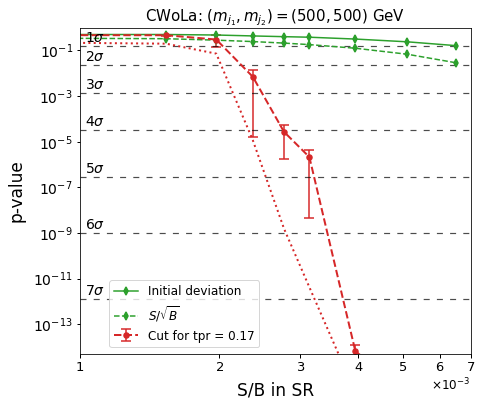

In [14]:
###################################################################################################################
#############################################    Make p-values plot    ############################################
###################################################################################################################

fig = plt.figure(figsize=(5*1.4,6))
ax = fig.add_subplot(1, 1, 1)

# Plot the initial p-value (i.e. 100% selection) and the naive expected significance
plt.errorbar(S_B_CW[:9], p0_median_100_tpr[:9], xerr=None, yerr=None, 
             marker='d', color='C2', markersize=5, linestyle='-', linewidth=1.5, label=r'Initial deviation', 
             lolims=False, capsize=5, elinewidth=1.5, capthick=2, markeredgewidth=1.5)
plt.errorbar(S_B_CW[:9], p0_expected[:9], xerr=None, yerr=None, 
             marker='d', color='C2', markersize=5, linestyle='--', linewidth=1.5, label=r'$S/\sqrt{B}$', 
             lolims=False, capsize=5, elinewidth=1.5, capthick=2, markeredgewidth=1.5)

# Plot the expected significance for the cuts corresponding to the 17%, 13% and 6% signal efficiency
plt.errorbar(S_B_CW[:9], p0_expected_after_017_tpr[:9], xerr=None, yerr=None, 
             marker='o', color='C3', markersize=0, linestyle='dotted', linewidth=2,
             lolims=False, capsize=5, elinewidth=1.5, capthick=2, markeredgewidth=1.5)
plt.errorbar(S_B_CW[:9], p0_expected_after_013_tpr[:9], xerr=None, yerr=None, 
             marker='o', color='C1', markersize=0, linestyle='dotted', linewidth=2,
             lolims=False, capsize=5, elinewidth=1.5, capthick=2, markeredgewidth=1.5)
plt.errorbar(S_B_CW[:9], p0_expected_after_006_tpr[:9], xerr=None, yerr=None, 
             marker='o', color='C4', markersize=0, linestyle='dotted', linewidth=2, 
             lolims=False, capsize=5, elinewidth=1.5, capthick=2, markeredgewidth=1.5)


# Plot the p-value for the cuts corresponding to the 17%, 13% and 6% signal efficiency
plt.errorbar(S_B_CW[:9], p0_median_017_tpr[:9], xerr=None, yerr=p0_mad_017_tpr[:9], 
             marker='o', color='C3', markersize=5, linestyle='--', linewidth=2, label=r'Cut for tpr = 0.17',
             lolims=False, capsize=5, elinewidth=1.5, capthick=2, markeredgewidth=1.5)
plt.errorbar(S_B_CW[:9], p0_median_013_tpr[:9], xerr=None, yerr=p0_mad_013_tpr[:9], 
             marker='o', color='C1', markersize=5, linestyle='--', linewidth=2, label=r'Cut for tpr = 0.13',
             lolims=False, capsize=5, elinewidth=1.5, capthick=2, markeredgewidth=1.5)
plt.errorbar(S_B_CW[:9], p0_median_006_tpr[:9], xerr=None, yerr=p0_mad_006_tpr[:9], 
             marker='o', color='C4', markersize=5, linestyle='--', linewidth=2, label=r'Cut for tpr = 0.06',
             lolims=False, capsize=5, elinewidth=1.5, capthick=2, markeredgewidth=1.5)

# Plot lines with the fixed standard deviations
dashes = [5,6]
linestyles = [{'dashes':[5,6]},{'linestyle':'-'},{'linestyle':'-'},{'linestyle':'-'},{'linestyle':'-'}]

for sigma in range(1,8):
    ax.axhline(1-norm.cdf(sigma),dashes=dashes,color='black',linewidth=1.2, alpha=0.7)
    if sigma > 0:
        sigmastring = r'$' + str(sigma) + '\sigma$'
        ax.text(1.08*10**-3,(1-norm.cdf(sigma))*1.1,sigmastring,va='bottom',ha='center',fontsize=14) 
ax.set_xscale('log')
ax.set_yscale('log')

# Options
plt.title(r'CWoLa: $(m_{j_{1}}, m_{j_{2}}) = (500, 500)$ GeV', fontsize=15)
plt.xlabel(r'S/B in SR', fontsize=17, labelpad=8)
plt.ylabel(r'p-value', fontsize=17, labelpad=8)
plt.legend(loc='lower left', bbox_to_anchor=(0.06,0.001), fontsize=12)
plt.xlim(xmin=10**-3, xmax = 7*10**-3)
plt.ylim(ymin=5*10**-15, ymax=1)
plt.tick_params(which='both', direction='out', length=3.5, width=1, labelsize=14)

# Set x-axis lscale and labels
plt.semilogx()
plt.gca().set_xticks([1*10**-3, 2*10**-3, 3*10**-3, 4*10**-3, 5*10**-3, 6*10**-3, 7*10**-3])
plt.gca().set_xticklabels([r'$1$', r'$2$', r'$3$', r'$4$', r'$5$', r'$6$', r'$7$'], fontsize=13)
plt.gca().get_xaxis().set_major_formatter(ScalarFormatter())
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0), useMathText=True)
plt.gca().xaxis.offsetText.set_fontsize(12)

# Save figure
plt.savefig("/home/pablo/Documentos/lbl/olympics/anomaly_detection_analysis/plots_efficiency/CWoLa_m500_pvalues_efficiency_SR.pdf", 
            bbox_inches = 'tight', pad_inches = 0)

In [15]:
#######################################################################################################
##########################################   Save to file   ###########################################
#######################################################################################################    

save_path = '/home/pablo/Documentos/lbl/olympics/anomaly_detection_analysis/CWoLa_signal_m500_efficiency_analysis/'

# Create dataset and classes to store important information
file_m500 = h5py.File(save_path + 'CWoLa_pvalues_from_SIC_info_m500_corrected.hdf5', 'w')

# Save basic info
S_B_CW_tofile = file_m500.create_dataset('S_B', (len(S_B_CW), ), dtype='f8')
S_sqrt_B_CW_tofile = file_m500.create_dataset('S_sqrt_B', (len(S_sqrt_B_CW), ), dtype='f8')
p0_expected_tofile = file_m500.create_dataset('p0_expected', (len(p0_expected), ), dtype='f8')
p0_median_100_tpr_tofile = file_m500.create_dataset('p0_median_100_tpr', (len(p0_median_100_tpr), ), dtype='f8')

# Save median info
p0_median_017_tpr_tofile = file_m500.create_dataset('p0_median_017_tpr', (len(p0_median_017_tpr), ), dtype='f8')
p0_median_013_tpr_tofile = file_m500.create_dataset('p0_median_013_tpr', (len(p0_median_013_tpr), ), dtype='f8')
p0_median_006_tpr_tofile = file_m500.create_dataset('p0_median_006_tpr', (len(p0_median_006_tpr), ), dtype='f8')

# Save mad info
p0_mad_017_tpr_tofile = file_m500.create_dataset('p0_mad_017_tpr', (len(p0_mad_017_tpr), ), dtype='f8')
p0_mad_013_tpr_tofile = file_m500.create_dataset('p0_mad_013_tpr', (len(p0_mad_013_tpr), ), dtype='f8')
p0_mad_006_tpr_tofile = file_m500.create_dataset('p0_mad_006_tpr', (len(p0_mad_006_tpr), ), dtype='f8')

# Save expected pvalues
p0_expected_after_100_tpr_tofile = file_m500.create_dataset('p0_expected_after_100_tpr', (len(p0_expected_after_100_tpr), ), dtype='f8')
p0_expected_after_017_tpr_tofile = file_m500.create_dataset('p0_expected_after_017_tpr', (len(p0_expected_after_017_tpr), ), dtype='f8')
p0_expected_after_013_tpr_tofile = file_m500.create_dataset('p0_expected_after_013_tpr', (len(p0_expected_after_013_tpr), ), dtype='f8')
p0_expected_after_006_tpr_tofile = file_m500.create_dataset('p0_expected_after_006_tpr', (len(p0_expected_after_006_tpr), ), dtype='f8')

# Fill dataset
S_B_CW_tofile[:] = S_B_CW
S_sqrt_B_CW_tofile[:] = S_sqrt_B_CW
p0_expected_tofile[:] = p0_expected
p0_median_100_tpr_tofile[:] = p0_median_100_tpr
p0_median_017_tpr_tofile[:] = p0_median_017_tpr
p0_median_013_tpr_tofile[:] = p0_median_013_tpr
p0_median_006_tpr_tofile[:] = p0_median_006_tpr
p0_mad_017_tpr_tofile[:] = p0_mad_017_tpr
p0_mad_013_tpr_tofile[:] = p0_mad_013_tpr
p0_mad_006_tpr_tofile[:] = p0_mad_006_tpr
p0_expected_after_100_tpr_tofile[:] = p0_expected_after_100_tpr
p0_expected_after_017_tpr_tofile[:] = p0_expected_after_017_tpr
p0_expected_after_013_tpr_tofile[:] = p0_expected_after_013_tpr
p0_expected_after_006_tpr_tofile[:] = p0_expected_after_006_tpr

file_m500.close()